In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

In [8]:
#DATA

df_fake = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/Fake.csv")
df_true = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/True.csv")

# Adding a column to indicate whether the news is true or fake
df_true['isfake'] = 0
df_fake['isfake'] = 1

df = pd.concat([df_true, df_fake]).reset_index(drop=True)
df.drop(columns=['date'], inplace=True)

# Combining 'title' and 'text' colmuns together
#df['original'] = df['tweet']
df['original'] = df['title'] + ' ' + df['text']


In [23]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['washington', 'reuters'])

# Removing stopwords and words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

df['clean'] = df['original'].apply(preprocess)

# All unique words present in dataset in one string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller special coun...
3        russia probe helped australian diplomat trump ...
4        trump wants postal service charge amazon shipm...
                               ...                        
44893    mcpain john mccain furious iran treated sailor...
44894    justice yahoo settles mail privacy class actio...
44895    sunnistan allied safe zone plan territorial bo...
44896    blow million jazeera america finally calls qui...
44897    navy sailors held iranian military signs neoco...
Name: clean_joined, Length: 44898, dtype: object


In [24]:
#WORD2VEC

# Target class is 'isfake'
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2)

# Creating list of lists of unigrams - training corpus
corpus_train = x_train
lst_coprus_train = []
for string in corpus_train:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_coprus_train.append(lst_grams)

# Fitting Word2Vec
nlp = word2vec.Word2Vec(lst_coprus_train, vector_size=300, window=8, min_count=1, sg=1)

# Listing similar words to 'trump'
print(nlp.wv.most_similar('trump'))

# Creating list of lists of unigrams - testing corpus
corpus_test = x_test
lst_coprus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_coprus_test.append(lst_grams)


[('donald', 0.7635288238525391), ('bails', 0.7007672190666199), ('flirted', 0.6927379369735718), ('scold', 0.680018961429596), ('yuuge', 0.6661972999572754), ('assailing', 0.6654286980628967), ('hesitance', 0.6652796864509583), ('contretemps', 0.6635866165161133), ('catty', 0.6578384041786194), ('rubiopresident', 0.6569938063621521)]


In [26]:
print(df.clean_joined[0])

budget fight looms republicans flip fiscal script head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise percent fiscal conse

In [25]:
#TOKENIZATION AND PADDING

# Tokenizing words and creating sequneces of tokenized words
tokenizer = Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_coprus_train)
dic_vocabulary = tokenizer.word_index

lst_text2seq_train = tokenizer.texts_to_sequences(lst_coprus_train)
lst_text2seq_test = tokenizer.texts_to_sequences(lst_coprus_test)


# Adding padding
padded_train = pad_sequences(lst_text2seq_train, maxlen=40, padding='post', truncating='post')
padded_test = pad_sequences(lst_text2seq_test, maxlen=40, truncating='post')


# Starting the embedding matrix
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word, idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] = nlp.wv[word]
    # If word not in model skip and row stays all 0s
    except:
        pass

In [27]:
#SHOWING HOW A TEXT FROM DF IS TRANSFORMED INTO A SEQ WITH PADDING

i = 0

## list of text
len_txt = len(df["clean_joined"].iloc[i].split())
print("from: ", df["clean_joined"].iloc[i], "| len:", len_txt)

## sequence of token ids
len_tokens = len(padded_train[i])
print("to: ", padded_train[i], "| len:", len(padded_train[i]))

## vocabulary
print("check: ", df["clean_joined"].iloc[i].split()[0], " -- idx in vocabulary -->", dic_vocabulary[df["clean_joined"].iloc[i].split()[0]])
print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  budget fight looms republicans flip fiscal script head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise percent fisca

In [28]:
#BUILDING AND TRAINING MODEL

model = Sequential()
# takes the sequences as input and the word vectors as weightstakes the sequences as input and the word vectors as weights
model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings]))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100))) # 100 memory units (smart neurons)
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)

#Training the model
training = model.fit(padded_train, y_train, batch_size=64, validation_split=0.3, epochs=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         29867400  
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 30,188,401
Trainable params: 30,188,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
393/393 [==============================] - 268s 664ms/step - loss: 0.1032 - accuracy: 0.9615 - val

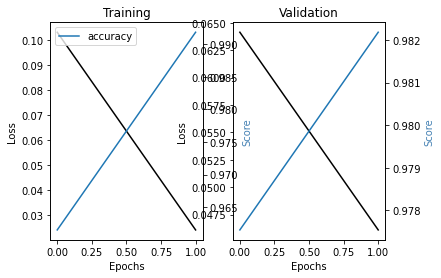

Model accuracy is :  0.9829621380846325
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4262
           1       0.99      0.98      0.98      4718

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



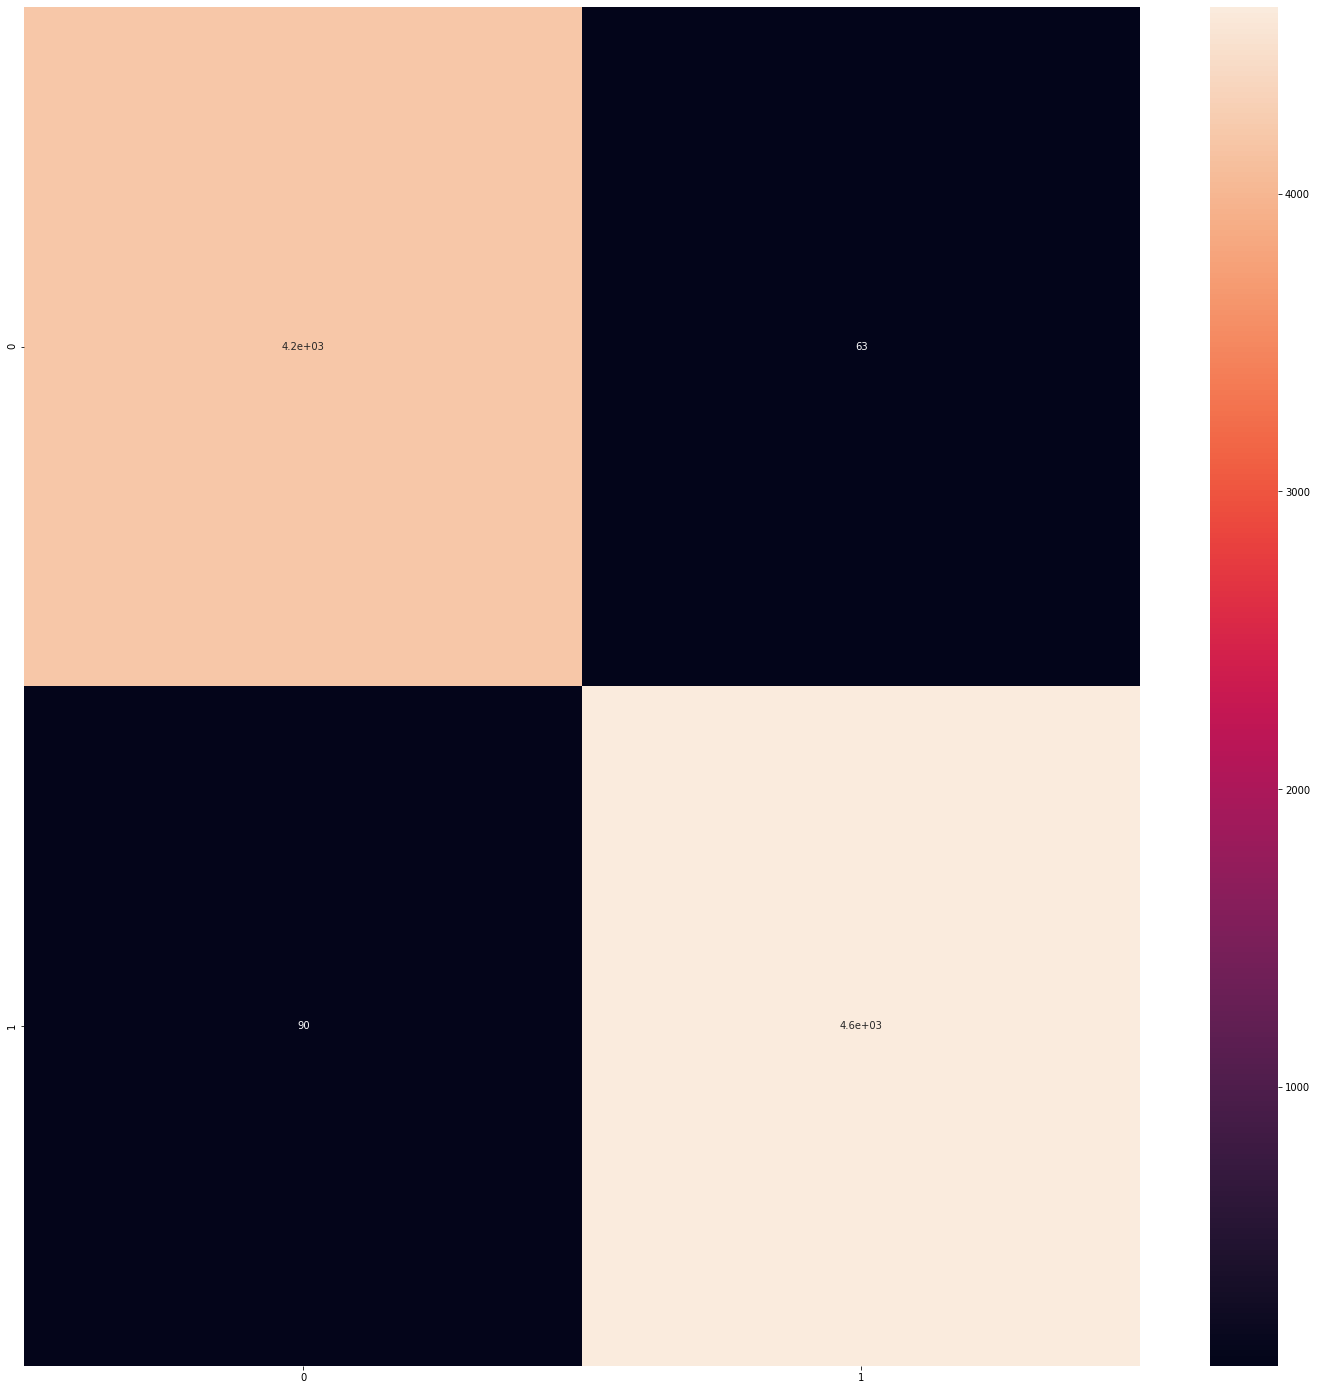

In [29]:
#ASSESING TRAINED MODEL PERFORMANCE

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

## Plot confusion matrix

pred = model.predict(padded_test)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()